In [31]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold
from sklearn.svm import SVC

from micromlgen import port

In [32]:
def extract_mfcc(files, n_mfccs):
    # Dictionary to store mfcc values
    class_dict = {}
    for i in range(n_mfccs):
        name = "mfcc_" + str(i+1)
        class_dict[name] = []

    # Column for filename
    class_dict["filename"] = []
    
    # Loop through all the files for the class
    for filename in files:
        # Load audio file using librosa
        x, sr = librosa.load(filename)
        # Extract mfccs
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfccs)
        # Compute mean of the MFCC features along the time axis
        mfccs_mean = np.mean(mfccs.T, axis=0)
        # Turning results into dataframe
        for index, val in enumerate(mfccs_mean):
            col = "mfcc_" + str(index+1)
            class_dict[col].append(val)
        # Saving filename to dict
        class_dict["filename"].append(filename.split('/')[-2]+'_'+filename.split('/')[-1])

    return pd.DataFrame(class_dict)

In [33]:
def run_models(df):

    # Prep features and target
    features = df.drop(columns=["Class", "filename"])
    feature_names = features.columns
    target = df.Class
    class_labels = np.unique(target)
    cv = LeaveOneOut()

    # SVM
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)
    svm = SVC(kernel="linear")
    svm = svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print(y_pred)
    print(f"Train/test split accuracy SVM: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print()
    
    svm = SVC(kernel="linear")
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):

        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        svm = svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"SVM Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    plot_confusion_matrix(actual_class, predicted_class, "SVM", class_labels)
    svm_feature_importance = abs(svm.coef_[0])
    plot_feature_importance(svm_feature_importance, feature_names, "SVM")

    # Random Forest
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)
    rf = RandomForestClassifier()
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f"Train/test split accuracy RF: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print()
    
    rf = RandomForestClassifier()
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):
        
        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"RF Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    plot_confusion_matrix(actual_class, predicted_class, "Random Forest", class_labels)
    rf_feature_importance = rf.feature_importances_
    plot_feature_importance(rf_feature_importance, feature_names, "Random Forest")

    ## EXPORTING MODEL TO C CODE
    # rf_c_code = port(rf)
    # file_path = "MFCC_only_RF_model.c"
    # with open(file_path, "w") as file:
    #     file.write(rf_c_code)

    # XGBoost 
    # xgb = GradientBoostingClassifier()
    # actual_class = []
    # predicted_class = []
    
    # for train_index, test_index in cv.split(features):
        
    #     # Splitting into training and testing
    #     X_train, X_test = features.take(train_index), features.take(test_index)
    #     y_train, y_test = target[train_index], target[test_index]

    #     xgb.fit(X_train, y_train)
    #     y_pred = xgb.predict(X_test)

    #     actual_class.append(y_test.item())
    #     predicted_class.append(y_pred[0])

    # print(f"XGBoost Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    # plot_confusion_matrix(actual_class, predicted_class, "XGBoost", class_labels)
    # xgb_feature_importance = xgb.feature_importances_
    # plot_feature_importance(xgb_feature_importance, feature_names, "XGBoost")

In [34]:
def plot_feature_importance(feature_importance, feature_names, model_name):
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    sorted_importance = feature_importance[sorted_idx]
    sorted_features = np.array(feature_names)[sorted_idx]

    # Create the bar chart
    plt.figure()
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

In [35]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name} (MFCCs only)')
    plt.show()

# MFCCs = 13
['rain_heavy' 'rain_heavy' 'rain_heavy' 'rain_light' 'rain_heavy'
 'rain_heavy' 'rain_heavy' 'rain_light' 'rain_heavy' 'rain_heavy'
 'rain_med' 'rain_heavy' 'rain_heavy' 'whitenoise' 'rain_heavy'
 'rain_heavy' 'rain_heavy' 'whitenoise' 'hail_heavy' 'rain_heavy'
 'rain_light' 'rain_heavy' 'rain_heavy' 'rain_light' 'rain_heavy'
 'rain_heavy' 'rain_light' 'hail_heavy' 'hail_light' 'rain_heavy'
 'rain_light' 'rain_heavy' 'rain_heavy' 'hail_heavy' 'rain_heavy'
 'rain_light' 'whitenoise' 'rain_heavy' 'rain_heavy' 'hail_heavy'
 'rain_light' 'rain_heavy' 'rain_heavy' 'rain_heavy' 'rain_light'
 'rain_light' 'hail_heavy' 'rain_light' 'rain_heavy' 'rain_med'
 'rain_heavy' 'rain_heavy' 'whitenoise' 'rain_heavy' 'rain_heavy'
 'rain_light' 'rain_light' 'rain_med' 'rain_light' 'rain_heavy'
 'rain_light' 'rain_heavy' 'rain_light' 'rain_heavy' 'rain_med'
 'rain_heavy' 'rain_heavy' 'rain_heavy' 'rain_med' 'rain_light'
 'rain_heavy' 'rain_heavy' 'rain_med' 'rain_heavy' 'rain_heavy'
 'whiteno

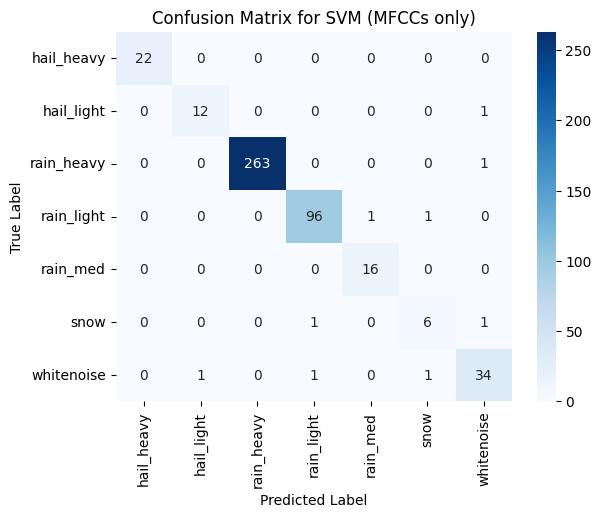

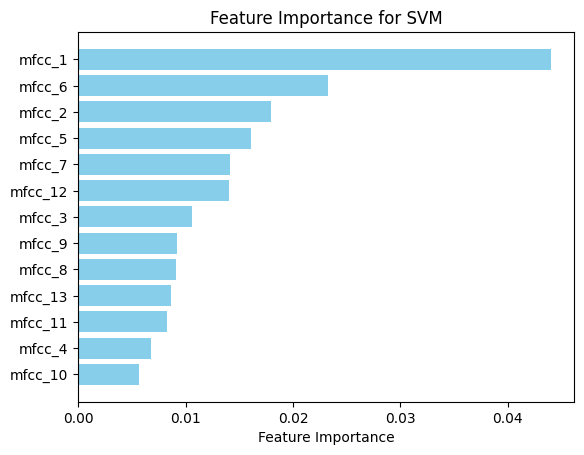

Train/test split accuracy RF: 94.74%

RF Accuracy: 97.38%


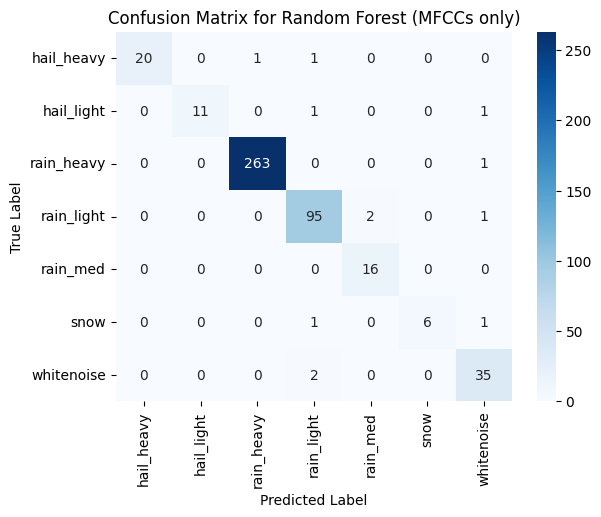

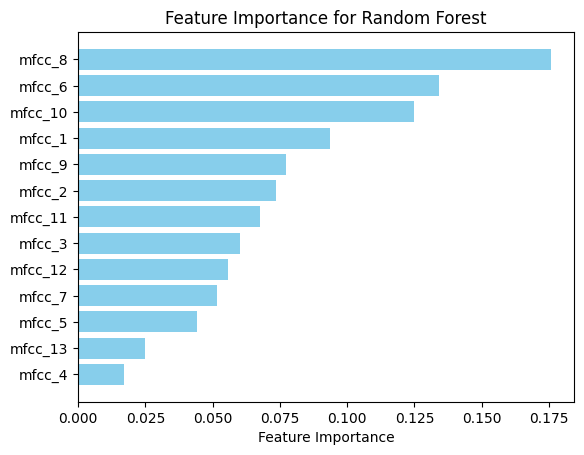

In [36]:
# Locate all audio files from new testing samples folder
all_audio_files = glob.glob("../microphone-sampling/TestingSamples2BatterySetup/*/*.WAV")

# Dictionary to store file names by class
class_dict = {}
for file in all_audio_files:
    file_class = file.split('/')[3]
    if file_class not in class_dict:
        class_dict[file_class] = []
    class_dict[file_class].append(file)

# Extracting MFFCs for each class, testing different # of MFFCs, and storing results in dataframe
potential_num_mfccs = np.arange(13,14)
for n_mfcc in potential_num_mfccs:
    all_class_dfs_list = []
    for key in class_dict:
        df = extract_mfcc(class_dict[key], n_mfcc)
        df["Class"] = key
        all_class_dfs_list.append(df)

    all_classes_df = pd.concat(all_class_dfs_list, ignore_index=True)
    print(f'# MFCCs = {n_mfcc}')
    run_models(all_classes_df)
    print()

In [23]:
# Map string names to their integer labels used in predictions, drop irrelevant columns
all_classes_df = pd.concat(all_class_dfs_list, ignore_index=True)
mapping = {
    string_label: index for index, string_label in enumerate(np.unique(all_classes_df["Class"]))
}
all_classes_df["label"] = all_classes_df["Class"].map(mapping)
all_classes_df.drop(["filename", "Class"], axis=1, inplace=True)
all_classes_df.to_csv("mfccs_only.csv", index=False)

In [29]:
from collections import Counter
print(Counter(all_classes_df.label))

Counter({2: 264, 3: 98, 6: 37, 0: 22, 4: 16, 1: 13, 5: 8})


In [30]:
all_classes_df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
0,-349.378540,52.382401,-8.858160,6.372537,-8.588493,8.792961,2.598988,7.800683,-0.550519,9.217299,10.704021,16.371220,14.983733,3
1,-363.597992,49.066460,-8.634185,10.601698,-9.905052,9.165816,-1.422468,8.275226,-2.526036,9.912940,8.611097,15.839087,12.197832,3
2,-350.072815,50.654297,-9.846224,7.089751,-12.943428,7.565587,0.597184,9.573232,-2.426839,9.327165,8.549190,15.922858,12.895616,3
3,-351.017853,51.905502,-11.019196,2.629327,-11.636314,6.231915,3.245962,8.407377,-1.009351,8.870161,11.713670,15.629916,14.592668,3
4,-321.593170,58.797836,-14.974872,-5.499442,-16.651566,3.752087,4.051542,5.811818,-4.005813,9.449664,13.572712,16.375458,14.490077,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,-327.925110,58.309841,-11.496773,1.416261,-11.153939,0.432864,-5.003625,4.740157,2.618091,10.441208,12.605475,20.605433,17.983028,1
454,-305.711945,44.461891,-19.126768,2.737281,-5.409375,2.470021,-6.093148,7.128239,5.438093,9.335022,9.870933,18.040148,17.303667,1
455,-323.522552,64.366447,-13.875262,-3.498724,-7.645740,5.599994,-0.252797,6.318476,4.662850,8.871380,9.946808,16.512066,17.336422,1
456,-318.345551,55.429134,-14.012546,0.124950,-10.855465,-0.672153,-7.119845,4.385257,3.502031,10.149508,12.605271,20.550066,18.155533,1
